# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

Описание данных
Данные геологоразведки трёх регионов находятся в файлах: 
* /datasets/geo_data_0.csv.
* /datasets/geo_data_1.csv.
* /datasets/geo_data_2.csv.

id — уникальный идентификатор скважины;

f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);

product — объём запасов в скважине (тыс. баррелей).

Условия задачи:
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

## Загрузка и подготовка данных

In [198]:
#импорт библиотек
import numpy as np
import pandas as pd
import seaborn as sns

from numpy.random import RandomState

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [199]:
#Выгрузка данных для локальной работы, так и для проверки
try:
    data_0 = pd.read_csv('/datasets/geo_data_0.csv')
    data_1 = pd.read_csv('/datasets/geo_data_1.csv')
    data_2 = pd.read_csv('/datasets/geo_data_2.csv')
except:
    data_0 = pd.read_csv('geo_data_0.csv')
    data_1 = pd.read_csv('geo_data_1.csv')
    data_2 = pd.read_csv('geo_data_2.csv')

In [200]:
# Функция для отображения общей информации
def review(df):
    info = \
    display(df.head()),
    df.info(),
    print()
    print('-' * 40, '\n', 
          'Количество дубликатов:',df.duplicated().sum(),
          '\n',
          'Количество дубликатов по id:',df.id.duplicated().sum(),
          '\n', '-' * 39),
    display(df.describe(),
    sns.heatmap(df.corr(), 
                linewidths=1, 
                cmap='Oranges',
                fmt='0.4f',
                annot=True))

"Region_1" 
 ________________________________________


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

---------------------------------------- 
 Количество дубликатов: 0 
 Количество дубликатов по id: 10 
 ---------------------------------------


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


<AxesSubplot:>

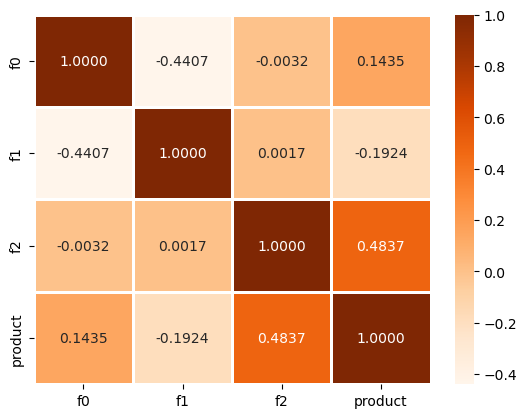

In [201]:
print('"Region_1"','\n','_'*40)
review(data_0)

"Region_2" 
 ________________________________________


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

---------------------------------------- 
 Количество дубликатов: 0 
 Количество дубликатов по id: 4 
 ---------------------------------------


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


<AxesSubplot:>

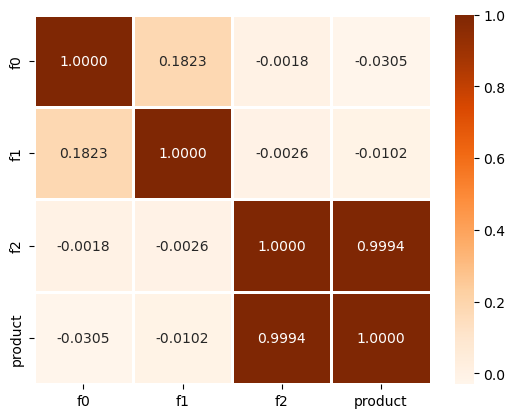

In [202]:
print('"Region_2"','\n','_'*40)
review(data_1)

"Region_3" 
 ________________________________________


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

---------------------------------------- 
 Количество дубликатов: 0 
 Количество дубликатов по id: 4 
 ---------------------------------------


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


<AxesSubplot:>

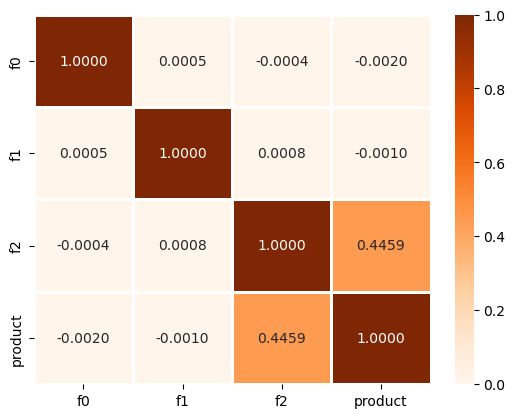

In [203]:
print('"Region_3"','\n','_'*40)
review(data_2)

**Вывод**
- Каждый выгруженный файл состоит из 100 тысяч записей, без пропусков. Среди столбцов имеется id - обозначение каждой точки, три параметра f0, f1, f2 - они обозначают значимые признаки точек и product - объем запасов продукта в точке. product является целевым признаком, f0, f1, f2 - обучающие признаки.
- При полной проверке на дубликатов по общим строкам все хорошо, но при проверке id мы можем наблюдать на дублирующие точки. Это может указывать на несколько раз проведенные замеры точек. Не будем изменять эти данные.

Так же:
  1) В первом регионе можно наблюдать среднюю корреляцию между признаком f2 и product (0.48). Признаки f0 и f1 имеют среднюю отрицательную корреляцию между собой (-0.44).
  2) Во втором регионе корреляция между f2 и product приближается к 1. Между этими параметрами существует прямая линейная зависимость. Необходимо дополнительно исследовать данные для второго региона.
  3) В третьем регионе корреляция между f2 и product похожа на первый регион (0.45). Коэффициенты среди всех остальных признаков близятся у нулю.

## Обучение и проверка модели

Условия задачи:
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).

In [204]:
features_1 = data_0.drop(['product', 'id'], axis=1)
target_1 = data_0['product']
features_train_1, features_valid_1, target_train_1, target_valid_1 = train_test_split(\
                                                    features_1, target_1,\
                                                    test_size=.25,   random_state=12345)

features_2 = data_1.drop(['product', 'id'], axis=1)
target_2 = data_1['product']
features_train_2, features_valid_2, target_train_2, target_valid_2 = train_test_split(\
                                                    features_2, target_2,\
                                                    test_size=.25,   random_state=12345)
features_3 = data_2.drop(['product', 'id'], axis=1)
target_3 = data_2['product']
features_train_3, features_valid_3, target_train_3, target_valid_3 = train_test_split(\
                                                    features_3, target_3,\
                                                    test_size=.25,   random_state=12345)

In [205]:
print('Shapes\nTraining set: {}\n              {}'
  .format(features_train_1.shape,target_train_1.shape))
print('Shapes\nTest set:     {}\n              {}'
  .format(features_valid_2.shape,target_valid_2.shape))

Shapes
Training set: (75000, 3)
              (75000,)
Shapes
Test set:     (25000, 3)
              (25000,)


In [206]:
record_data = {'r2':[], 'rmse':[], 'predicted_mean':[], 'target_mean':[]}
region_predictions = []

def lnr(features_train, features_valid, target_train, target_valid):
    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    region_predictions.append(pd.Series(index=target_valid.index, data=predictions))
    rmse = mean_squared_error(target_valid, predictions, squared=False)
    
    record_data['r2'].append(r2_score(target_valid, predictions))
    record_data['rmse'].append(rmse)
    record_data['predicted_mean'].append(predictions.mean())
    record_data['target_mean'].append(target_valid.mean())

*LinearRegression* **Region 1**

In [207]:
lnr(features_train_1,features_valid_1, target_train_1, target_valid_1)

*LinearRegression* **Region 2**

In [208]:
lnr(features_train_2,features_valid_2, target_train_2, target_valid_2)

*LinearRegression* **Region 3**

In [209]:
lnr(features_train_3,features_valid_3, target_train_3, target_valid_3)

In [210]:
region_predict = pd.DataFrame(region_predictions,
                              index=['region_1', 'region_2', 'region_3']).T
region_predict.describe()

,region_1,region_2,region_3
count,25000.000000,25000.000000,25000.000000
mean,92.592568,68.728547,94.965046
std,23.176994,46.010225,19.853733
min,-9.367846,-1.893774,17.131597
25%,76.652232,28.536661,81.388500
50%,92.661884,57.851586,95.031204
75%,108.437632,109.346485,108.492663
max,180.180713,139.818970,165.856833


In [211]:
region_metrics = pd.DataFrame(metrics_data,
                              index=['region_1', 'region_2', 'region_3']).T
region_metrics

,region_1,region_2,region_3
r2,0.279943,0.999623,0.205248
rmse,37.579422,0.893099,40.029709
predicted_mean,92.592568,68.728547,94.965046
target_mean,92.078597,68.723136,94.884233


В целом предсказанное среднее очень похоже во всех регионах на истинные значения. Метрика R2 больше, а метрика RMSE меньше в первом регионе, по сравнению с третьим.

## Подготовка к расчёту прибыли

Условие задачи
- При разведке региона проводится исследование 500 точек, 200 лучших для разработки.
- Бюджет на разработку месторождений — 10 млрд рублей, стоимость бурения одной скважины — 50 млн рублей.
- Один баррель сырья приносит 4500 рублей прибыли.
- Не рассматривать регионы, в которых риск убытков выше 2.5%. Из оставшихся выбирается регион с наибольшей средней прибылью.

In [212]:
exp_points = 500
best_points = 200
budget = 10_000_000_000
count_one_borehole = 50_000_000
one_barrel_profit = 450_000
risk_losses = 0.025

In [213]:
min_product = count_one_borehole / one_barrel_profit
print(
    'Минимальный запас скважины для безубыточной разработки: {:.2f} тыс. баррелей'
    .format(min_product))

Минимальный запас скважины для безубыточной разработки: 111.11 тыс. баррелей


Минимальный запас продукта скважины необходимый для безубыточности разработки равен 111.11 тыс. баррелей. 

Средние показатели запасов во всех регионах ниже минимального количества для окупаемости.

## Расчёт прибыли и рисков 

**Функция расчета прибыли**

Напишем функцию для определения прибыли в регионе с учетом затрат на разработку скважин. Используем в функции предсказания модели линейной регрессии, для определения наиболее выгодных точек разработки.

In [214]:
def revenue(target, probabilities, count):
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:count]
    return one_barrel_profit * selected.sum()-budget

In [215]:
result_1 = revenue(data_0['product'],region_predict['region_1'], best_points)
result_2 = revenue(data_1['product'],region_predict['region_2'], best_points)
result_3 = revenue(data_2['product'],region_predict['region_3'], best_points)
print('''Прибыль 200 скважин:
Регион 1 - {:.2f} млрд. руб.
Регион 2 - {:.2f} млрд. руб.
Регион 3 - {:.2f} млрд. руб.
'''.format(result_1/1e9,result_2/1e9,result_3/1e9))

Прибыль 200 скважин:
Регион 1 - 3.32 млрд. руб.
Регион 2 - 2.42 млрд. руб.
Регион 3 - 2.71 млрд. руб.



При выборе разрабатываемых скважин по предсказаниям модели наиболее прибыльным регионом оказался первый. За ним третий регион.

**Bootstrap**

Применим технику Bootstrap с 1000 выборок, чтобы определить прибыльность регионов. Напишем функцию, которая применяет Bootstrap к данным региона и считает метрики: среднюю прибыль, риск убытков и доверительный интервал 95%. Для определения доверительного интервала воспользуемся методом квантилей.

In [216]:
state = np.random.RandomState(12345)

def confidence_interval(target, probabilities):
    values = []
    for i in range(1000):
        sample = pd.Series(probabilities).sample(n = exp_points, replace=True, random_state = state)
        values.append(revenue(target, sample, best_points))
    values = pd.Series(values)
    print('Средняя прибыль скважин:', values.mean()/1e8)
    print('Риск убытков:', (values < 0).mean()*100 ,"%")
    
    lower = values.quantile(0.025)*10
    upper = values.quantile(0.975)*10
    return round(lower,2)/1e9, round(upper,2)/1e9

In [217]:
print('Скважина 1')
print('95% доверительный итервал:',
      confidence_interval(data_0['product'], region_predict['region_1']))
print('_'*40)
print('Скважина 2')
print('95% доверительный итервал:',
      confidence_interval(data_1['product'], region_predict['region_2']))
print('_'*40)
print('Скважина 3')
print("95% доверительный итервал:",
      confidence_interval(data_2['product'], region_predict['region_3']))

Скважина 1
Средняя прибыль скважин: 3.9616498480237103
Риск убытков: 6.9 %
95% доверительный итервал: (-1.1121554589, 9.097669415530001)
________________________________________
Скважина 2
Средняя прибыль скважин: 4.611558172772399
Риск убытков: 0.7000000000000001 %
95% доверительный итервал: (0.78050810752, 8.62952060264)
________________________________________
Скважина 3
Средняя прибыль скважин: 3.9295047517060375
Риск убытков: 6.5 %
95% доверительный итервал: (-1.12227625379, 9.34562914551)


**Вывод**

Мы посчитали риски и прибыли для трех регионов. Техникой Bootstrap получили значения средней прибыли, риска убытков и доверительный интервал 95% для каждого региона.

Все регионы показали положительную среднюю прибыль. Наибольшая средняя прибыль наблюдается во втором регионе  4.59, далее третий 3.88. и первый регионы 3.90.
По значению риска убытков, меньше максимального значения 2.5% только во втором регионе примерно - 1.0%. В первом регионе 6.8%, в третьем 6.6%.
Нижняя граница доверительного интервала иллюстрирует, что риск убытков в первом и третьем регионах выше требуемого значения, а именно нижняя граница отрицательная в первом и третьем регионах.
Заявленным в задании требованиям соответствует только второй регион.